# Call Your Very Own Stable Diffusion Model Using Natural Language 

In [ ]:
import os
import openai
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler

# REMEMBER to set this up
openai.api_key = "sk-"

device = "cuda:0" if torch.cuda.is_available() else "cpu"
context = autocast if device == "cuda:0" else nullcontext
dtype = torch.float16 if device == "cuda:0" else torch.float32


ddim_scheduler = DDIMScheduler(
        beta_start=0.00085,
        beta_end=0.012,
        beta_schedule="scaled_linear",
        clip_sample=False,
        set_alpha_to_one=False,
    )

pipe = StableDiffusionPipeline.from_pretrained(
    "/home/ubuntu/model_default", 
    torch_dtype=torch.float16,
    scheduler=ddim_scheduler,
    safety_checker=None).to("cuda")

pipe = pipe.to(device)


In [61]:
def runSD(prompt, n_samples, steps, guidance_scale):
    print('---------------------------------')
    print(prompt)
    print(n_samples)
    print(steps)
    print(guidance_scale)
    print('---------------------------------')
    with context("cuda"):
        results = pipe(
            n_samples * [prompt], guidance_scale=guidance_scale, num_inference_steps=steps
        ).images
    return results

In [62]:
def execute_function(func, *args, **kwargs):
    try:
        result = func(*args, **kwargs)
        return result
    except Exception as e:
        return f"Error: {e}"

In [63]:
function_descriptions = [
            {
                "name": "runSD",
                "description": "Generate images of Pokemon creatures from a text description of the creature.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "prompt": {
                            "type": "string",
                            "description": "The text description of the creature",
                        },
                        "n_samples": {
                            "type": "number",
                            "description": "The number of output images. Default to 2.",
                        },
                        "steps": {
                            "type": "number",
                            "description": "The number of iteration steps for the algorithm. Default to 20.",
                        },
                        "guidance_scale": {
                            "type": "number",
                            "description": "The guidance scale controls how much the generated image should follow the prompt. The larger the value, the more closely the generated images follow the prompt. Typically value is somewhere between 7.0 to 13.0. Default to 10.0",
                        },
                    },
                    "required": ["object", "n_samples", "steps", "guidance_scale"],
                },
            }
        ]

In [64]:
user_query = "Create three pictures with very high guidance and 38 steps, using the following prompt: photo, colorful cinematic portrait of aabbccddeeffgg, armor, cyberpunk,background made of brain cells, back light, organic, art by greg rutkowski, ultrarealistic, leica 30mm"
openai_model_name = "gpt-4-0613" # You can also try gpt-3.5-turbo-0613, but gpt-4-0613 is definitely smarter
function_call = "auto" # allow the model to choose whether or not it responds with a function.

response = openai.ChatCompletion.create(
    model=openai_model_name,    
    
    messages=[{"role": "user", "content": user_query}],
            
    functions=function_descriptions,
    
    function_call="auto",
)

print(response)

{
  "id": "chatcmpl-7iGWs6OHyJkAMrDQLY2JZOU1IVB4c",
  "object": "chat.completion",
  "created": 1690784326,
  "model": "gpt-4-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": null,
        "function_call": {
          "name": "runSD",
          "arguments": "{\n  \"prompt\": \"photo, colorful cinematic portrait of aabbccddeeffgg, armor, cyberpunk,background made of brain cells, back light, organic, art by greg rutkowski, ultrarealistic, leica 30mm\",\n  \"n_samples\": 3,\n  \"steps\": 38,\n  \"guidance_scale\": 13.0\n}"
        }
      },
      "finish_reason": "function_call"
    }
  ],
  "usage": {
    "prompt_tokens": 217,
    "completion_tokens": 86,
    "total_tokens": 303
  }
}


In [65]:
func = eval(response["choices"][0]["message"]['function_call']['name'])

kwargs = eval(response["choices"][0]["message"]['function_call']['arguments'])

function_response = execute_function(func, **kwargs)

print("function input:")
print(func)
print(kwargs)
print("function response: ")
print(function_response)

---------------------------------
photo, colorful cinematic portrait of aabbccddeeffgg, armor, cyberpunk,background made of brain cells, back light, organic, art by greg rutkowski, ultrarealistic, leica 30mm
3
38
13.0
---------------------------------


  0%|          | 0/38 [00:00<?, ?it/s]

function input:
<function runSD at 0x7f1ff686baf0>
{'prompt': 'photo, colorful cinematic portrait of aabbccddeeffgg, armor, cyberpunk,background made of brain cells, back light, organic, art by greg rutkowski, ultrarealistic, leica 30mm', 'n_samples': 3, 'steps': 38, 'guidance_scale': 13.0}
function response: 
[<PIL.Image.Image image mode=RGB size=512x512 at 0x7F1FC585F4F0>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7F1FC585F070>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7F1FC585FDF0>]


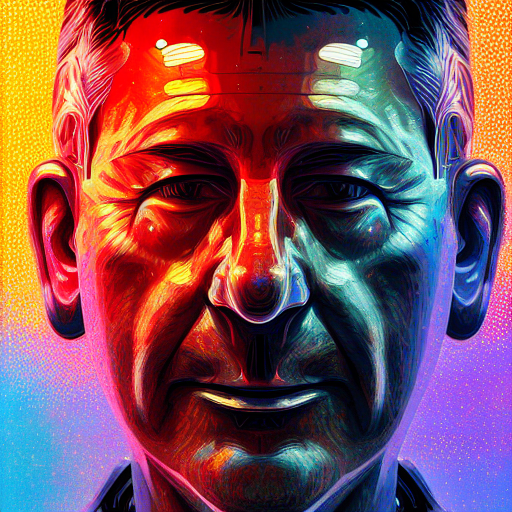

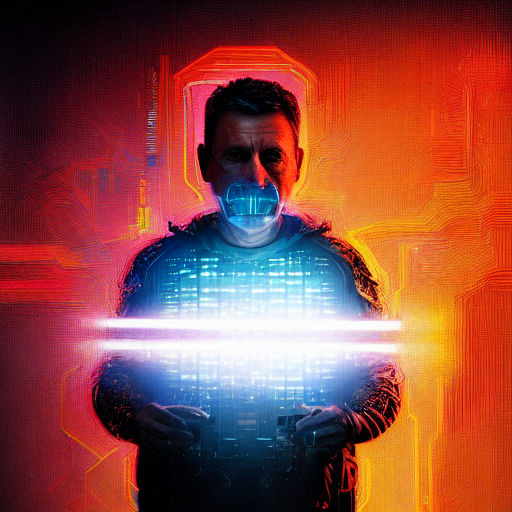

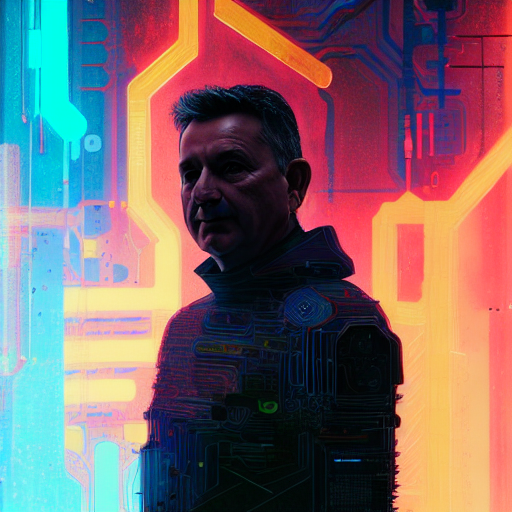

In [66]:
from IPython.display import display
from PIL import Image
for image in function_response:
    display(image)